In [22]:
import cv2
import time
import argparse
import numpy as np
import tensorflow as tf
from dataset.image_utils import resize_image, resize_back
from model.post_process import batch_non_max_suppression
import matplotlib.pyplot as plt
import colorsys

In [23]:
img_size = 640
image_target_size = img_size

In [24]:
def draw_box(image, label, classes_map=None):
    # label: xyxy
    box = label[:, 0:4].copy()
    classes = label[:, -1]   
    
    print(box)
    if np.max(box) <= 1:
        box[:, [0, 2]] = box[:, [0, 2]] * image.shape[1]
        box[:, [1, 3]] = box[:, [1, 3]] * image.shape[0]

    if not isinstance(box, int):
        box = box.astype(np.int16)

    image_h, image_w, _ = image.shape
    
    num_classes = len(classes_map) if classes_map is not None else len(range(int(np.max(classes)) + 1))
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    bbox_thick = int(0.6 * (image_h + image_w) / 600)   
    font_scale = 0.5

    for i in range(label.shape[0]):
        x1y1 = tuple(box[i, 0:2])
        x2y2 = tuple(box[i, 2:4])
        class_ind = int(classes[i])
        bbox_color = colors[class_ind]
        image = cv2.rectangle(image, x1y1, x2y2, bbox_color, bbox_thick)

        # show labels
        if classes_map is not None:
            class_ind = classes_map[class_ind]
        else:
            class_ind = str(class_ind)

        if label.shape[-1] == 6:
            score = ': ' + str(round(label[i, -2], 2))
        else:
            score = ''

        bbox_text = '%s %s' % (class_ind, score)
        t_size = cv2.getTextSize(bbox_text, 0, font_scale, thickness=bbox_thick//2)[0]
        cv2.rectangle(image, x1y1, (x1y1[0] + t_size[0], x1y1[1] - t_size[1] - 3), bbox_color, -1)  # filled
        cv2.putText(image, bbox_text, (x1y1[0], x1y1[1]-2), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

    return image


In [25]:
def image_demo(img, model, img_size=640, class_names=None, conf_threshold=0.4, iou_threshold=0.3):
    original_shape = img.shape
    
    img_input = resize_image(img, target_sizes=img_size)
    img_input = img_input[np.newaxis, ...].astype(np.float32)
    img_input = img_input / 255.

    pred_bbox = model(img_input)
    pred_bbox = [tf.reshape(x, (tf.shape(x)[0], -1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=1)  # batch_size * -1 * (num_class + 5)

    bboxes = batch_non_max_suppression(pred_bbox, conf_threshold=conf_threshold, iou_threshold=iou_threshold)
    bboxes = bboxes[0].numpy()  # batch is 1 for detect

    bboxes = resize_back(bboxes, target_sizes=img_size, original_shape=original_shape)  # adjust box to original size
    if bboxes.any():
        print(np.array(bboxes))
        image = draw_box(img, np.array(bboxes), class_names)
        plt.imshow(image)
    else:
        print('No box detected')

In [26]:
def test_image_demo(img_dir, model_dir, img_size=640, class_name_dir=None, conf_threshold=0.4, iou_threshold=0.3):
    img = cv2.imread(img_dir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))

    if class_name_dir:
        class_names = {idx: name for idx, name in enumerate(open(class_name_dir).read().splitlines())}
    else:
        class_names = None    
    model = tf.saved_model.load(model_dir)
    image_demo(img, model, img_size=img_size, class_names=class_names,
               conf_threshold=conf_threshold, iou_threshold=iou_threshold)

[[-2.9253854e+02 -2.9114951e+02  9.4583301e+02  8.7792236e+02
   3.2537225e-01  1.4000000e+01]]
[[-292.53854 -291.1495   945.833    877.92236]]


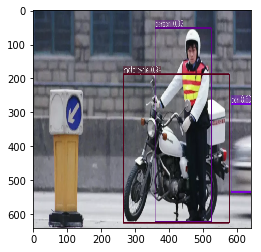

In [27]:
test_image_demo(r'C:\yolo\yolo v5\Yolov5-main\data\sample\demo1.png', 
                r'C:\yolo\yolo v5\weights\yolov5', 640, 
                r'C:\yolo\yolo v5\Yolov5-main\data\sample\voc.names',
                0.3, 0.4)


[[-2.9255756e+02 -2.9115735e+02  9.4589093e+02  8.7797607e+02
   3.2484299e-01  1.4000000e+01]]
[[-292.55756 -291.15735  945.8909   877.9761 ]]


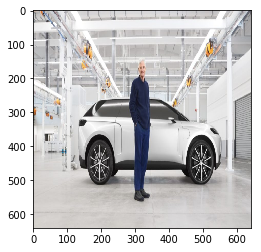

In [28]:
test_image_demo(r'C:\yolo\yolo v5\1.jpg', 
                r'C:\yolo\yolo v5\weights\yolov5', 640, 
                r'C:\yolo\yolo v5\Yolov5-main\data\sample\voc.names',
                0.3, 0.4)